In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
sns.set(rc={"figure.figsize":(20, 8.5)})

In [7]:
df = pd.read_csv("shots_2022.csv")
df = df[(df['shotOnEmptyNet']==0)&(df['shotWasOnGoal']>=0)&(df['isPlayoffGame']==0)]
df['teamScoredOn'] = df.apply(lambda x: x['awayTeamCode'] if x['awayTeamGoals']>0 else x['homeTeamCode'], axis=1)
df = df.loc[:, ["shotID", "teamScoredOn", "xCord", "yCord", "goal", "teamCode", "game_id", "goalieNameForShot", 
                "shooterName", "shotAngle", "shotDistance", "shotType", "time"]]

#Map shot quality from 1 to 6 based on distance & if taken from behind the net
    #Rank = 1 if taken outside of offensive zone from distance greater than farthest in-zone point
    #Rank = 2 if taken from anywhere behind goal line or distance >= farthest in-zone point - 15ft
    #Rank = 3 if shot was taken outside slot or from behind the net
    #Rank = 4 if shot was taken from >= 27 feet away from net
    #Rank = 5 if shot was taken  >=21 feet away from net
    #Rank = 6 if shot was taken >= 9.5 feet away
    #Rank = 7 if shot was taken >= 7 feet away
    #Rank = 8 if shot was taken from >= 6 feet away
    #Rank = 9 if shot was taken from < 6 feet away
df['quality'] = df.apply(lambda x: 
    1 if (((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2)))&(x['yCord']<=36)&(x['yCord']>=-36)) else (
    2 if ((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2))-15) else(
    3 if (x['yCord']>=24)|(x['yCord']<=-24)|(x['xCord']<-89)|(x['xCord']>89) else(
    4 if (x['shotDistance']>= 27) else (
    5 if (x['shotDistance']>= 21) else( 
    6 if (x['shotDistance']>= 9.5) else (
    7 if (x['shotDistance']>= 7) else (
    8 if (x['shotDistance']>= 6) else 9))))))), axis=1)

df_goals=df[df['goal']>0]
def create_circle(coords, c):
    return plt.Circle(xy=(coords[0],coords[1]), radius=15, color=c, fill=False)
def plot_rink(df, title):
    rink = sns.scatterplot(x='xCord', y='yCord', data=df, hue='quality', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.title(title)
    #Create rink lines
    rink.axvline(0, color='red')
    rink.axvline(-25, color='blue')
    rink.axvline(25, color='blue')
    rink.axvline(89, color='red')
    rink.axvline(-89, color='red')
    rink.add_patch(create_circle([0,0], 'blue'))
    rink.add_patch(create_circle([69,22], 'red'))
    rink.add_patch(create_circle([-69,22], 'red'))
    rink.add_patch(create_circle([69,-22], 'red'))
    rink.add_patch(create_circle([-69,-22], 'red'))
    rink.grid(False)
    plt.xlim(-100,100)
    plt.ylim(-42.5,42.5)

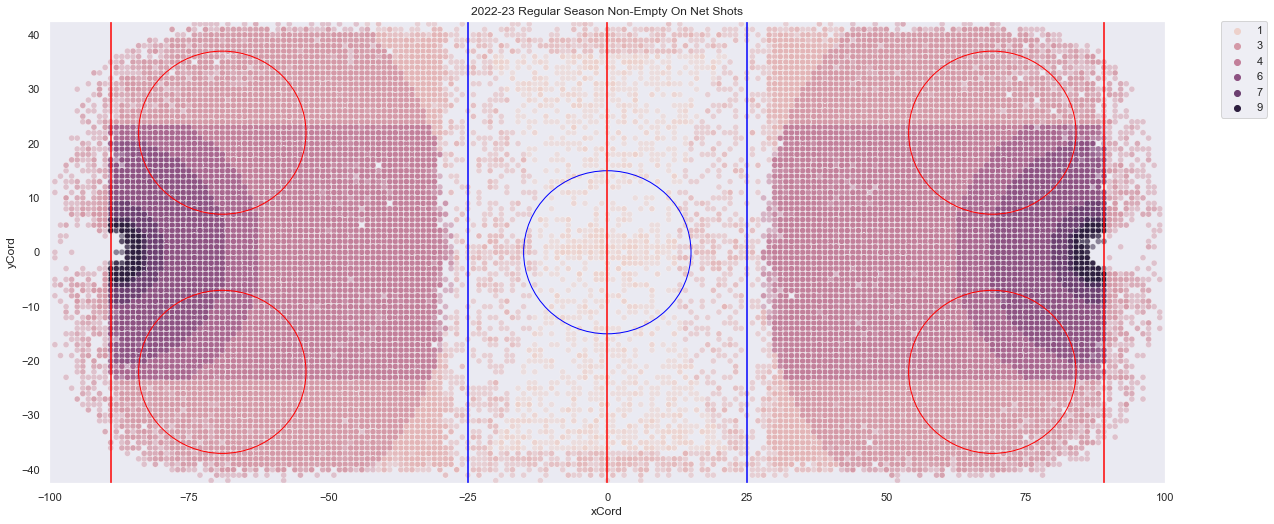

In [8]:
df_saves=df[df['goal']==0]
plot_rink(df_saves, "2022-23 Regular Season Non-Empty On Net Shots")

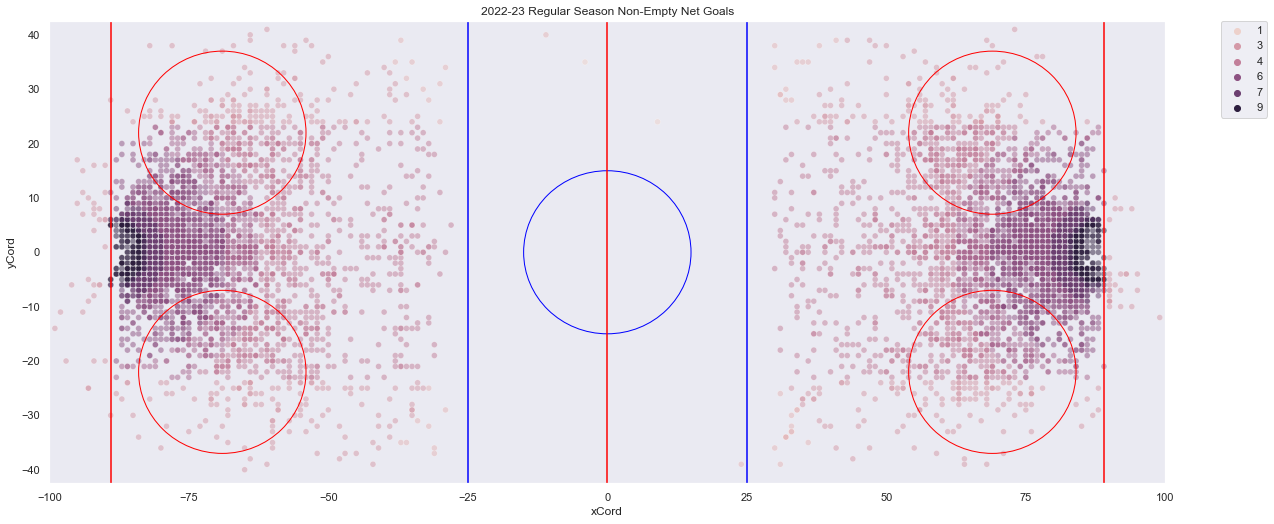

In [9]:
plot_rink(df_goals, "2022-23 Regular Season Non-Empty Net Goals")

In [10]:
#Get percentage of shots that are goals based on the quality
df2 = df
df2['goal_percentage_by_quality'] = ((df2.groupby('quality')['goal'].transform('sum') / df2.groupby('quality')['goal']
                                     .transform('count')) * 100)
average_goal_percentage_by_shot_quality = df2.drop_duplicates('quality').sort_values('quality')
print(df2.drop_duplicates('quality').corr()['quality']['goal_percentage_by_quality'])

0.9879008228288916
1:2, 2:44, 3:555, 4:1764, 5:997, 6:2564, 7:1239


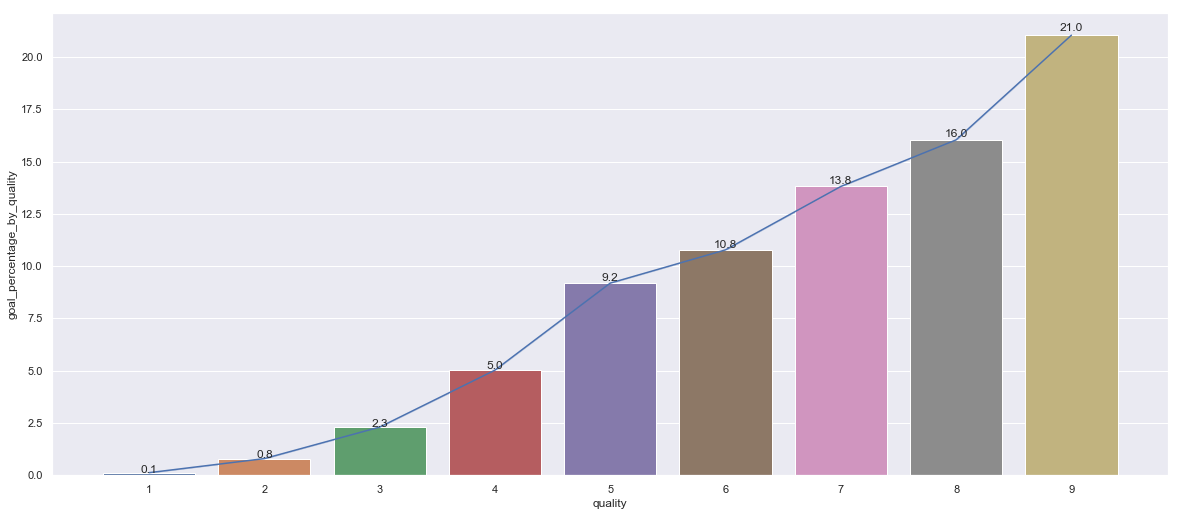

In [11]:
bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=df2.drop_duplicates('quality'))
sns.lineplot(x=(df2['quality']-1), y='goal_percentage_by_quality', data = df2)
#Function from https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
show_values(bar_plot)

In [28]:
def get_goalie_SPAAsq(name, plot):
    # Check each goalie's shots in different qualities to see performance
    df_vasy = df[df['goalieNameForShot']==name]
    df_vasy['goal_percentage_by_quality'] = ((df_vasy.groupby('quality')['goal'].transform('sum') / 
                                             df_vasy.groupby('quality')['goal'].transform('count')) * 100)
    df_vasy_qualities = df_vasy.drop_duplicates('quality').sort_values('quality')
    
    if plot:
        bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=df_vasy.drop_duplicates('quality'))
        sns.lineplot(x=(df_vasy['quality']-1), y='goal_percentage_by_quality', data = df_vasy)
        sns.lineplot(x=(df2['quality']-1), y='goal_percentage_by_quality', data = df2, color='red')
        show_values(bar_plot)
    
    average_goal_percentage_by_shot_quality.rename(columns={'goal_percentage_by_quality': 'average_goal_percentage'}, 
                                                   inplace=True)

    # Merge the DataFrames on the 'quality' column
    merged_df = df_vasy_qualities.merge(average_goal_percentage_by_shot_quality, on='quality', how='left')

    # Calculate the difference and create a new column 'SPAAsq'
    merged_df['SPAAsq'] = merged_df['average_goal_percentage'] - merged_df['goal_percentage_by_quality']
    return merged_df['SPAAsq']

<ipython-input-28-02516bb5767a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vasy['goal_percentage_by_quality'] = ((df_vasy.groupby('quality')['goal'].transform('sum') /


0    0.123457
1   -0.380090
2    0.307757
3    1.014315
4   -0.388757
5    0.910710
6    1.894071
7    6.040549
8   -8.365253
Name: SPAAsq, dtype: float64

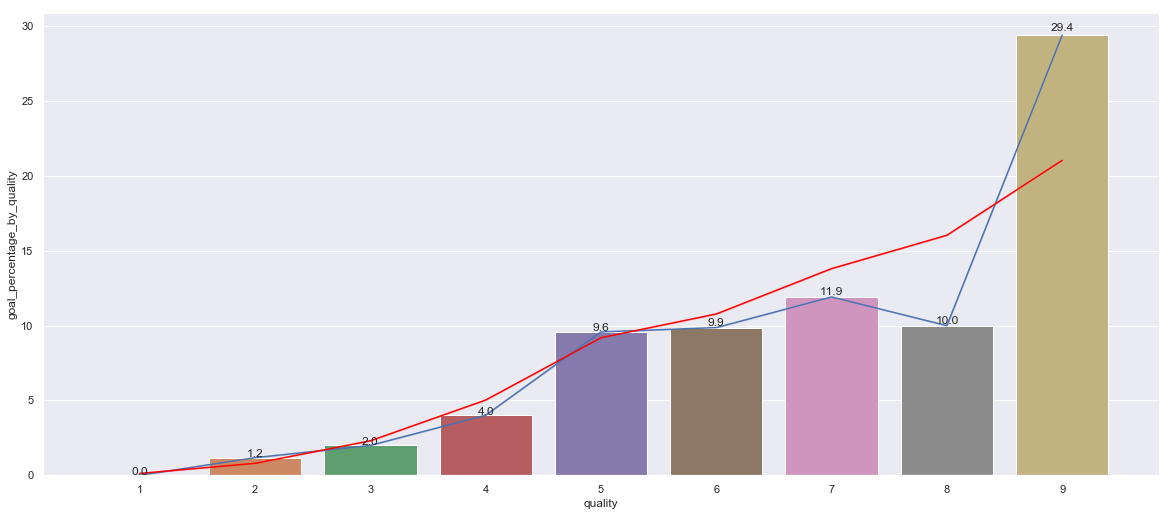

In [29]:
name = 'Andrei Vasilevskiy'
get_goalie_SPAAsq(name, True)

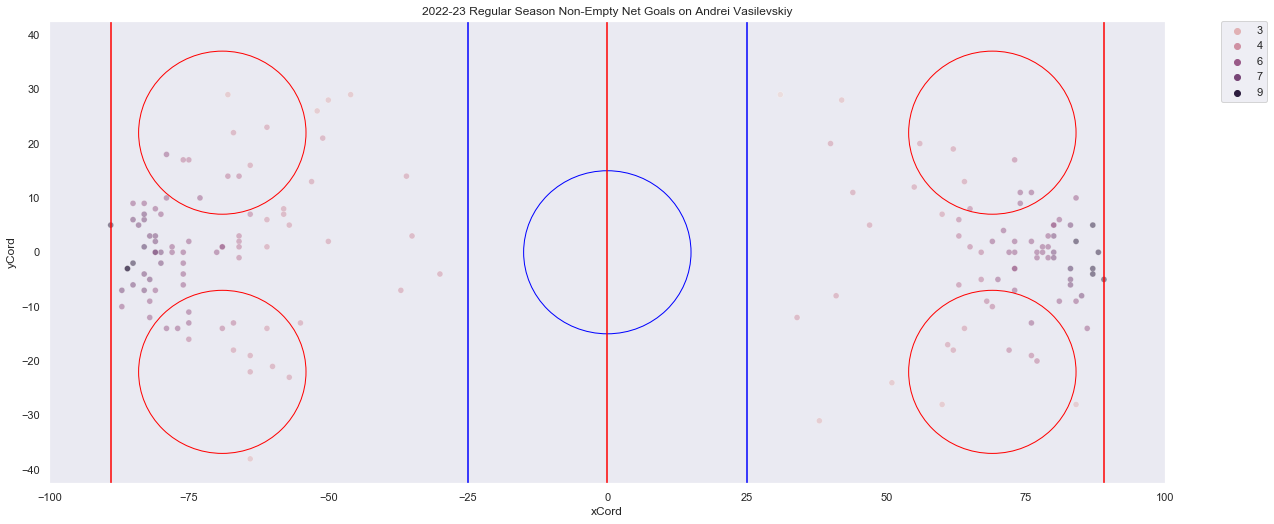

In [30]:
plot_rink(df_goals[df_goals['goalieNameForShot']==name], "2022-23 Regular Season Non-Empty Net Goals on "+name)

In [60]:
# get percentiles for SPAAsq for each 'quality'
goalies = df.drop_duplicates('goalieNameForShot').loc[:, ['goalieNameForShot', 'teamScoredOn']]
new_columns = goalies['goalieNameForShot'].apply(lambda x: get_goalie_SPAAsq(x, False))
new_columns.columns = ['SPAA_Quality1', 'SPAA_Quality2', 'SPAA_Quality3', 'SPAA_Quality4', 'SPAA_Quality5', 
                       'SPAA_Quality6', 'SPAA_Quality7', 'SPAA_Quality8', 'SPAA_Quality9']
goalies = pd.concat([goalies, new_columns], axis=1)
goalies.reset_index(drop=True, inplace=True)
goalies

<ipython-input-28-02516bb5767a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vasy['goal_percentage_by_quality'] = ((df_vasy.groupby('quality')['goal'].transform('sum') /


goalieNameForShot teamScoredOn  SPAA_Quality1  SPAA_Quality2  \
0         Juuse Saros          NSH       0.123457       0.796380   
1        James Reimer          NSH       0.123457       0.796380   
2      Kaapo Kahkonen          SJS       0.123457       0.796380   
3      Kevin Lankinen          SJS       0.123457       0.796380   
4     Igor Shesterkin          NYR       0.123457      -1.164404   
..                ...          ...            ...            ...   
101       Jon Gillies          CBJ       0.123457       0.796380   
102       Jet Greaves          TOR       0.796380       2.303765   
103  Leevi Merilainen          CAR       0.123457       0.796380   
104  Olle Eriksson Ek          ARI       0.796380      -5.388543   
105       Dustin Wolf          CGY       0.123457       0.796380   

     SPAA_Quality3  SPAA_Quality4  SPAA_Quality5  SPAA_Quality6  \
0         0.259472       1.238603       2.939787       0.847697   
1         0.914876      -0.610398      -1.608335      -3.245617   
2         1.116821      -1.458410      -6.599687      -2.618336   
3        -0.234306      -1.744832       2.939787       2.295508   
4        -0.250263       1.539704      -2.065624       2.018452   
..             ...            ...            ...            ...   
101       2.303765      -5.228334     -15.810213       0.254041   
102       5.028076       9.189787       0.780357       1.311169   
103      -3.578588     -16.024555       9.189787      -1.719643   
104       5.028076     -30.810213      10.780357     -11.188831   
105       2.303765       5.028076       9.189787      10.780357   

     SPAA_Quality7  SPAA_Quality8  SPAA_Quality9  
0         2.020776      -0.238521      -0.904708  
1        -1.946406      16.040549       6.412365  
2        -1.494953      -5.698582       1.046512  
3         6.564793      -6.181674       8.546512  
4         4.987640      -4.367615       5.894996  
..             ...            ...            ...  
101      -0.474545      21.046512            NaN  
102      16.040549      21.046512            NaN  
103      13.811169      16.040549      21.046512  
104     -78.953488            NaN            NaN  
105     -36.188831      16.040549            NaN  

[106 rows x 11 columns]

In [62]:
# Calculate the count of shots for each goalie by each quality level
shots_count_by_goalie_quality = df.groupby(['goalieNameForShot', 'quality']).size().unstack(fill_value=0)

# Iterate through the quality columns and create/update the corresponding GSAA columns in the goalies DataFrame
for quality in range(1, 10):
    spaa_col_name = f'SPAA_Quality{quality}'
    gsaa_col_name = f'GSAA_Quality{quality}'
    if spaa_col_name in goalies.columns:
        goalies[gsaa_col_name] = (goalies[spaa_col_name] / 100 * goalies['goalieNameForShot'] 
                                  .map(shots_count_by_goalie_quality[quality]))

goalies.drop(columns=[f'SPAA_Quality{quality}' for quality in range(1, 10)], inplace=True)
goalies.fillna(0, inplace=True)


goalies

goalieNameForShot teamScoredOn  GSAA_Quality1  GSAA_Quality2  \
0         Juuse Saros          NSH       0.046914       0.891946   
1        James Reimer          NSH       0.020988       0.660995   
2      Kaapo Kahkonen          SJS       0.023457       0.430045   
3      Kevin Lankinen          SJS       0.012346       0.302624   
4     Igor Shesterkin          NYR       0.039506      -1.187692   
..                ...          ...            ...            ...   
101       Jon Gillies          CBJ       0.001235       0.015928   
102       Jet Greaves          TOR       0.000000       0.023038   
103  Leevi Merilainen          CAR       0.002469       0.039819   
104  Olle Eriksson Ek          ARI       0.000000      -0.161656   
105       Dustin Wolf          CGY       0.003704       0.015928   

     GSAA_Quality3  GSAA_Quality4  GSAA_Quality5  GSAA_Quality6  \
0         1.523100      11.766725       9.877685       5.035318   
1         3.293554      -3.680700      -3.425754     -12.495627   
2         3.763688      -8.094177     -11.285464      -8.012109   
3        -0.461583      -4.379529       2.351830       3.787588   
4        -1.273837      10.593165      -4.771592      10.596872   
..             ...            ...            ...            ...   
101       0.506828      -2.039050      -1.264817       0.048268   
102       0.603369       1.654162       0.031214       0.262234   
103      -0.608360      -3.044666       0.735183      -0.137571   
104       0.653650      -5.545838       0.539018      -0.895106   
105       0.138226       0.402246       0.551387       0.754625   

     GSAA_Quality7  GSAA_Quality8  GSAA_Quality9  
0         4.627578      -0.102564      -0.370930  
1        -3.211571       4.651759       2.629070  
2        -1.465054      -1.310674       0.366279  
3         4.529707      -0.556351       0.683721  
4        10.174785      -2.140131       1.945349  
..             ...            ...            ...  
101      -0.033218       0.000000            NaN  
102       1.283244       0.631395            NaN  
103       1.104894       0.320811       0.210465  
104      -3.158140            NaN            NaN  
105      -0.723777       0.320811            NaN  

[106 rows x 11 columns]